# Introduction

Some initial things about our project and the data

# Import Libraries

In [ ]:
#!pip install pyLDAvis

In [ ]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
from transformers import AutoTokenizer
import getpass
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from gensim.models import Word2Vec
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# May be needed afterwards.
#!pip install transformers
#!pip install accelerate
#!pip install --upgrade jinja2
#!pip install -U sentence-transformers
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install --upgrade bitsandbytes
#!pip install sentencepiece

# Download the dataset

In [ ]:
# Download latest version
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
path = kagglehub.dataset_download("tirendazacademy/fifa-world-cup-2022-tweets")
print("Path to dataset files:", path)

100%|██████████| 1.38M/1.38M [00:00<00:00, 78.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/tirendazacademy/fifa-world-cup-2022-tweets/versions/1


In [ ]:
# Load the dataset
data = pd.read_csv(path + "/fifa_world_cup_2022_tweets.csv", index_col=0)
print(data.shape)
data.head(10)

(22524, 5)


,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative
5,2022-11-20 23:57:32+00:00,0,Twitter for Android,"And like, will the mexican fans be able to scr...",negative
6,2022-11-20 23:57:06+00:00,0,Twitter for Android,Look like a only me and the Jamaican football ...,neutral
7,2022-11-20 23:57:05+00:00,0,Twitter for Android,Really? Football on a Monday morning at 9 and ...,negative
8,2022-11-20 23:56:10+00:00,1,Twitter for iPhone,"As the World Cup starts in Qatar, it’s Black A...",positive
9,2022-11-20 23:56:08+00:00,0,Twitter for iPhone,#WorldCup2022 @ITVSport &amp; @LFSYSTEMMUSIC g...,positive


In [ ]:
# To Get the overall info ofcour data (data types, missing values, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22524 entries, 0 to 22523
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date Created     22524 non-null  object
 1   Number of Likes  22524 non-null  int64 
 2   Source of Tweet  22524 non-null  object
 3   Tweet            22524 non-null  object
 4   Sentiment        22524 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [ ]:
data = data[['Tweet','Sentiment']]
data

,Tweet,Sentiment
0,What are we drinking today @TucanTribe \n@MadB...,neutral
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,Worth reading while watching #WorldCup2022 htt...,positive
3,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,"If the BBC cares so much about human rights, h...",negative
...,...,...
22519,Here We go World cup 2022 #WorldCup2022,positive
22520,Anderlecht confirms former Viborg FF's Jesper ...,neutral
22521,Great thread to read before the start of #Worl...,positive
22522,Raphinha wants Brazil to be united at the #Wor...,positive


# Preprocessing

In [ ]:
# Drop the duplicates within data to avoid bias and clean data
print(data.shape)
data = data.drop_duplicates()

(22524, 2)


In [ ]:
#sanity check
print(data.shape)

(22360, 2)


In [ ]:
#check for null values. we dont have any.
data.isnull().sum()

,0
Tweet,0
Sentiment,0


In [ ]:
#EDA
countsentiment = data['Sentiment'].value_counts()
print(countsentiment)

Sentiment
positive    8425
neutral     8188
negative    5747
Name: count, dtype: int64


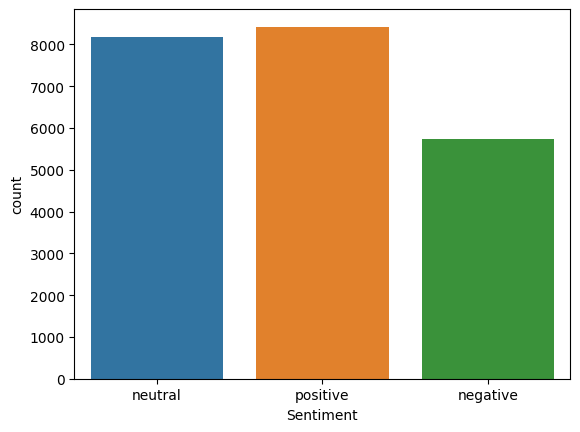

In [ ]:
#plot it in a scetterplot
sns.countplot(x='Sentiment', data = data, hue = 'Sentiment');

Some notes:
--we can see that most of the tweets are positive, followed by neutral. This may indicate us the enthusiasm and the positive expectation of the fans. As it seems to have created positive impressions.

In [ ]:
#Text preprocessing of the tweets
#lowercase the tweets
def lowercase_text(text):
    return str(text).lower()

In [ ]:
# Apply the function to tweets.
# Remember to reassign back to the same column for the changes to take effect.
# Preview your results
data['Tweet'] = data['Tweet'].apply(lowercase_text)
print("After lowercase transformation:")
rand_idxs = np.random.randint(0, len(data['Tweet']), size=10)
for idx in rand_idxs:
    print(f"Sentiment: {data['Sentiment'].iloc[idx]} - Tweet: {data['Tweet'].iloc[idx]}")

After lowercase transformation:
Sentiment: positive - Tweet: beer can condoms - this year's essential accessory for #worldcup2022 

#priceless https://t.co/nhzoaamgiu
Sentiment: neutral - Tweet: valencia was offside when he took that pen #worldcup2022
Sentiment: positive - Tweet: "after the angst and the acrimony, launch day is finally here"

fans are trekking to the al bayt stadium in al khor city for the #worldcup2022 opening ceremony and match 

@_jmcauley reports live from doha https://t.co/evsuc1gw7a
Sentiment: negative - Tweet: how was that disallowed then 😂 #worldcup2022
Sentiment: negative - Tweet: it’s already a load of bollocks #worldcup2022 #qatarworldcup2022 #qatar2022
Sentiment: negative - Tweet: the hypocrisy of the @bbc @garylineker on tv now, waiting to watch the game and all going on about why #worldcup2022 should not be in qatar. but sat there being paid and making money from it themselves. @alanshearer @alexscott
Sentiment: positive - Tweet: perhaps we should conside

/tmp/ipython-input-16-3970920050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lowercase_text)


In [ ]:
#stopwords removal
nltk.download('stopwords')
base_stopwords = set(stopwords.words('english'))
preserve = {'no', 'not', 'nor', 'never'}
custom_stopwords = base_stopwords - preserve
def remove_stopwords(text):
    words = str(text).split()
    filtered = [word for word in words if word not in custom_stopwords]
    result = ' '.join(filtered)

    if result != text:
        print(f"Before: {text}")
        print(f"After:  {result}\n")

    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['Tweet'] = data['Tweet'].apply(remove_stopwords)
data['Tweet'].head()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
iran has no national team this year in #worldcup2022‌ !

#kianpirfalak 
#mahsaamini 
#iranrevolution https://t.co/4vute8hhkv
After:  fuck football team islamic republic. iran no national team year #worldcup2022‌ ! #kianpirfalak #mahsaamini #iranrevolution https://t.co/4vute8hhkv

Before: i’m behind ghana and uruguay for the world cup. #fifaworldcup #worldcup2022 #qatarworldcup2022 https://t.co/4ye9oconn3
After:  i’m behind ghana uruguay world cup. #fifaworldcup #worldcup2022 #qatarworldcup2022 https://t.co/4ye9oconn3

Before: wouldn't mind if we were 6th.😁

#worldcup2022 ⚽️💪🏻
#poland 🇵🇱🇵🇱🇵🇱❤💪🏻 https://t.co/8ohrcvuhj7 https://t.co/bjxtgujxf1
After:  mind 6th.😁 #worldcup2022 ⚽️💪🏻 #poland 🇵🇱🇵🇱🇵🇱❤💪🏻 https://t.co/8ohrcvuhj7 https://t.co/bjxtgujxf1

Before: so exciting!!! #jungkook will be performing in the #worldcup2022 opening ceremony. the 1st korean artist to headline 💜💜💜💜💜💜💜
#btsarmy #btshistorymakers #bts_twt #fifaworldcup https://

/tmp/ipython-input-19-2244034832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(remove_stopwords)


,Tweet
0,drinking today @tucantribe @madbears_ @lkinc_a...
1,amazing @canadasocceren #worldcup2022 launch v...
2,worth reading watching #worldcup2022 https://t...
3,golden maknae shinning bright https://t.co/4ay...
4,"bbc cares much human rights, homosexual rights..."


In [ ]:
#remove URLs, because they didn't add semantic value, and to preserve privacy.
url_pattern = r"(?:https?|ftp)://[^\s/$.?#].[^\s]*"

def replace_urls(text):
    text_str = str(text)
    replaced_text = re.sub(url_pattern, 'URL', text_str)

    if replaced_text != text_str:
        print(f"Before: {text_str}")
        print(f"After:  {replaced_text}\n")

    return replaced_text

In [ ]:
data['Tweet'] = data['Tweet'].apply(replace_urls)
data['Tweet'].head()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#replace hastags & usernames for the same reasons.
def clean_mentions_hashtags(text):
    original = str(text)
    updated = original

    #Replace full email addresses
    updated = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', updated)

    #Replace users and hashtags
    updated = re.sub(r'@\w+|#\w+', '', updated)

    if updated != original:
        print(f"Before: {original}")
        print(f"After:  {updated}\n")


    return updated

In [ ]:
data['Tweet'] = data['Tweet'].apply(clean_mentions_hashtags)
data['Tweet'].head()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
After:  wash sport public? deflect cost corrupt regime winner sport one that’s lost      URL

Before: ⚽️ finally! 22nd fifa world cup kicks today. qatar play ecuador opening match. history world cup, hosts never started tournament defeat – 16 wins 6 draws: URL #wc2022 #worldcup2022 #qatar2022 URL
After:  ⚽️ finally! 22nd fifa world cup kicks today. qatar play ecuador opening match. history world cup, hosts never started tournament defeat – 16 wins 6 draws: URL    URL

Before: spot palestinian flag ?✨🇵🇸 hours away 🇶🇦 #qatarworldcup2022 #worldcup2022 URL
After:  spot palestinian flag ?✨🇵🇸 hours away 🇶🇦   URL

Before: spirit #worldcup2022. watching world cup match, make sure also play match well. 🤪#gbagagbabitters 🌿 dey you. #backtotheroots #gbagagba. URL
After:  spirit . watching world cup match, make sure also play match well. 🤪 🌿 dey you.  . URL

Before: guess player world cup wins history? 🏆⚽️ #fifaworldcup #qatar2022 #worldcup #f

/tmp/ipython-input-23-219291766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(clean_mentions_hashtags)


,Tweet
0,drinking today URL
1,amazing launch video. shows much face canada...
2,worth reading watching URL
3,golden maknae shinning bright URL
4,"bbc cares much human rights, homosexual rights..."


In [ ]:
#remove emojis without emoticons because they add sentiment
emoji_pattern = re.compile("["

    # Symbols & pictographs (e.g., 🔥🎉💡📦📱)
    u"\U0001F300-\U0001F5FF"

    # Transport & map symbols (e.g., 🚗✈️🚀🚉)
    u"\U0001F680-\U0001F6FF"

    # Flags (e.g., 🇺🇸🇬🇧🇨🇦 — these are pairs of regional indicators)
    u"\U0001F1E0-\U0001F1FF"

    # Dingbats (e.g., ✂️✈️✉️⚽)
    u"\u2700-\u27BF"

    # Supplemental Symbols & Pictographs (e.g., 🤖🥰🧠🦾)
    u"\U0001F900-\U0001F9FF"

    # Symbols & Pictographs Extended-A (e.g., 🪄🪅🪨)
    u"\U0001FA70-\U0001FAFF"

    # Miscellaneous symbols (e.g., ☀️☁️☂️⚡)
    u"\u2600-\u26FF"

    "]+", flags=re.UNICODE)

In [ ]:
def remove_emojis(text):
    if emoji_pattern.search(text):
        print(f"Before: {text}")
        text = emoji_pattern.sub('', text)
        print(f"After: {text}")
        print()
    return text

In [ ]:
data['Tweet'] = data['Tweet'].apply(remove_emojis)
data['Tweet'].head()

Before: world cup starts qatar, it’s black awareness day brazil✊🏽. despite atrocities linked year’s host fifa, soccer fundamental lower classes, mostly black brown, vini jr identifies    URL
After: world cup starts qatar, it’s black awareness day brazil. despite atrocities linked year’s host fifa, soccer fundamental lower classes, mostly black brown, vini jr identifies    URL

Before:   &amp;  go together well ‘hungry love’🫶 ⚽️👌
After:   &amp;  go together well ‘hungry love’ ️

Before: let’s go  🇺🇸🇺🇸🇺🇸
After: let’s go  

Before: good promising project.should look forward success project❤       URL
After: good promising project.should look forward success project       URL

Before: world cup prediction? 🇩🇪 über 🇧🇪 final.   
After: world cup prediction?  über  final.   

Before: ready day 2 ✌🏻    URL
After: ready day 2     URL

Before: cameroon✅   URL
After: cameroon   URL

Before: exciting things happening  headquarters🎉🎈🎊. don’t miss opportunity see  ⚽️!!!!    $ball URL
After: exciting

/tmp/ipython-input-26-3524784530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(remove_emojis)


,Tweet
0,drinking today URL
1,amazing launch video. shows much face canada...
2,worth reading watching URL
3,golden maknae shinning bright URL
4,"bbc cares much human rights, homosexual rights..."


In [ ]:
#remove non-alphabets
def clean_text(text, keep_punct=False):
    original = str(text)

    if keep_punct:
        # Keep only lowercase letters, spaces, and select punctuation (. ! ?), for capturing tone/sentiment
        cleaned = re.sub(r"[^a-z\s.!?]", "", original)
    else:
        # Keep only lowercase letters and spaces; remove all punctuation and symbols
        cleaned = re.sub(r"[^a-z\s]", "", original)

    # Normalize whitespace
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    if original != cleaned:
        print(f"Before: {text}")
        print(f"After:  {cleaned}\n")

    return cleaned

In [ ]:
data['Tweet'] = data['Tweet'].apply(lambda x: clean_text(x, keep_punct=True))

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
After:  would love english football brass band medleys gay anthems icons. surely fans see great humour too. could anyone stop that?

Before: wash sport public? deflect cost corrupt regime winner sport one that’s lost      URL
After:  wash sport public? deflect cost corrupt regime winner sport one thats lost

Before: ️ finally! 22nd fifa world cup kicks today. qatar play ecuador opening match. history world cup, hosts never started tournament defeat – 16 wins 6 draws: URL    URL
After:  finally! nd fifa world cup kicks today. qatar play ecuador opening match. history world cup hosts never started tournament defeat wins draws

Before: spot palestinian flag ? hours away    URL
After:  spot palestinian flag ? hours away

Before: spirit . watching world cup match, make sure also play match well.   dey you.  . URL
After:  spirit . watching world cup match make sure also play match well. dey you. .

Before: guess player world cup wins his

/tmp/ipython-input-28-2274118247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lambda x: clean_text(x, keep_punct=True))


In [ ]:
def remove_consecutive_letters(text, max_repeat=2):
    text_str = str(text)
    pattern = r'(\w)\1{' + str(max_repeat) + r',}'
    cleaned = re.sub(pattern, r'\1' * max_repeat, text_str)

    if cleaned != text_str:
        print(f"Before: {text_str}")
        print(f"After:  {cleaned}\n")

    return cleaned

In [ ]:
data['Tweet'] = data['Tweet'].apply(lambda x: remove_consecutive_letters(x, max_repeat=2))

Before: day lets watch fooootttttbaaaaallllllll!
After:  day lets watch foottbaall!

Before: reviewing video even header pass player forward direction. went straight even looks like deflected goalie. offside? pffft...more like .
After:  reviewing video even header pass player forward direction. went straight even looks like deflected goalie. offside? pfft...more like .

Before: lets gooooooooo team usa!!!
After:  lets goo team usa!!!

Before: less hours go s first match.lets go boysssss!!!
After:  less hours go s first match.lets go boyss!!!

Before: lmaoooo saudi dey memorise quran blow everything .btstwt .btsbighit
After:  lmaoo saudi dey memorise quran blow everything .btstwt .btsbighit

Before: worldcupcryptomeme kkkkkkkkk
After:  worldcupcryptomeme kk

Before: lets fucking gollllllllll
After:  lets fucking goll

Before: lets go argentinaaaa lets hope best. goat deserves it.
After:  lets go argentinaa lets hope best. goat deserves it.

Before: watched prediction video thought show 

/tmp/ipython-input-30-3337271836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lambda x: remove_consecutive_letters(x, max_repeat=2))


In [ ]:
#Lemmatization
# Download required NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# POS mapping function
# POS tags can be: ADJ (adjective), ADV (adverb), NOUN (noun), VERB (verb), etc
def get_wordnet_pos(tag):
    # Determine the WordNet POS tag based on the first letter of the input tag
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to Noun if no match


def lemmatize_text(text):
    original_text = str(text)
    # Split the text into individual words
    words = original_text.split()
    # Obtain Part of Speech (POS) tags for each word
    pos_tags = pos_tag(words)

    # Initialize lists to store lemmatized words and any changes
    lemmatized_words = []
    changes = []

    # Iterate over each word and its POS tag
    for word, tag in pos_tags:
        # Map the POS tag to a WordNet POS tag
        wn_tag = get_wordnet_pos(tag)
        # Lemmatize the word using the mapped POS tag
        lemma = lemmatizer.lemmatize(word, wn_tag)

        # Check if the lemmatized word is different from the original
        if lemma != word:
            # Record the change if a difference is found
            changes.append((word, lemma, tag))
        # Add the lemmatized word to the list
        lemmatized_words.append(lemma)

    # Join the lemmatized words back into a single string
    result = ' '.join(lemmatized_words)

    if changes:
        print(f"\nOriginal: {original_text}")
        print(f"Lemmatized: {result}")
        for original, lemma, pos in changes:
            print(f"  - {original} → {lemma}  (POS: {pos})")

    return result

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
data['Tweet'] = data['Tweet'].apply(lemmatize_text)
data['Tweet']

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  - biggest → big  (POS: JJS)
  - lets → let  (POS: VBZ)

Original: carry quatar airline ads given news coverage rightly exposes oppression exploitation society?
Lemmatized: carry quatar airline ad give news coverage rightly expose oppression exploitation society?
  - ads → ad  (POS: NNS)
  - given → give  (POS: VBN)
  - exposes → expose  (POS: VBZ)

Original: song crazy! captures emotion well. amount people not listening song made makes sad
Lemmatized: song crazy! capture emotion well. amount people not listen song make make sad
  - captures → capture  (POS: VBZ)
  - listening → listen  (POS: VBG)
  - made → make  (POS: VBD)
  - makes → make  (POS: VBZ)

Original: years ago! remember britney fifa world cup commercial pepsi
Lemmatized: year ago! remember britney fifa world cup commercial pepsi
  - years → year  (POS: NNS)

Original: check captaincy works best options md!
Lemmatized: check captaincy work best option md!
  - works → 

/tmp/ipython-input-34-2567611865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lemmatize_text)


,Tweet
0,drinking today
1,amaze launch video. show much face canada mens...
2,worth read watch
3,golden maknae shin bright
4,bbc care much human right homosexual right wom...
...,...
22519,go world cup
22520,anderlecht confirm former viborg ffs jesper fr...
22521,great thread read start
22522,raphinha want brazil united


In [ ]:
data.head(5)

,Tweet,Sentiment
0,drinking today,neutral
1,amaze launch video. show much face canada mens...,positive
2,worth read watch,positive
3,golden maknae shin bright,positive
4,bbc care much human right homosexual right wom...,negative


In [ ]:
Tweet = data["Tweet"]
Sentiment = data["Sentiment"]

In [ ]:
Tweet.head(5)

,Tweet
0,drinking today
1,amaze launch video. show much face canada mens...
2,worth read watch
3,golden maknae shin bright
4,bbc care much human right homosexual right wom...


In [ ]:
# Tokenize the corpus
tokenized_corpus = [comment.lower().split() for comment in Tweet]
tokenized_corpus

[['drinking', 'today'],
 ['amaze',
  'launch',
  'video.',
  'show',
  'much',
  'face',
  'canada',
  'mens',
  'national',
  'team',
  'change',
  'since',
  'last',
  'world',
  'cup',
  'entry',
  '.',
  'cant',
  'wait',
  'see',
  'boy',
  'action!',
  'canada',
  'fifa',
  'world',
  'cup',
  'open',
  'video'],
 ['worth', 'read', 'watch'],
 ['golden', 'maknae', 'shin', 'bright'],
 ['bbc',
  'care',
  'much',
  'human',
  'right',
  'homosexual',
  'right',
  'woman',
  'right',
  'not',
  'say',
  'open',
  'ceremony??',
  'say',
  'open',
  'ceremony??',
  'bbc',
  'censor',
  'open',
  'ceremony??'],
 ['like',
  'mexican',
  'fan',
  'able',
  'scream',
  'puto',
  'now?',
  'homophobic',
  'qatar?'],
 ['look', 'like', 'jamaican', 'football', 'team', 'naw', 'follow', 'worldcup'],
 ['really?',
  'football',
  'monday',
  'morning',
  '?',
  'need',
  'pinch',
  'myself.',
  'really',
  'happening?'],
 ['world',
  'cup',
  'start',
  'qatar',
  'it',
  'black',
  'awareness',
 

In [ ]:
#VECTORIZATION
X = data['Tweet']
y = data['Sentiment']
print(X)
y

0                                           drinking today
1        amaze launch video. show much face canada mens...
2                                         worth read watch
3                                golden maknae shin bright
4        bbc care much human right homosexual right wom...
                               ...                        
22519                                         go world cup
22520    anderlecht confirm former viborg ffs jesper fr...
22521                              great thread read start
22522                          raphinha want brazil united
22523    buy sot pinksale? confuse buy token pinksale s...
Name: Tweet, Length: 22360, dtype: object


,Sentiment
0,neutral
1,positive
2,positive
3,positive
4,negative
...,...
22519,positive
22520,neutral
22521,positive
22522,positive


In [ ]:
# we use the LabelEncoder() in order to map the classes 'positive', 'neutral' and 'negative' to numerical values

le = LabelEncoder()
y = le.fit_transform(y)
y

array([1, 2, 2, ..., 2, 2, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
print('X_train shape: ', X_train.shape, y_train.shape)
print('X_test shape: ', X_test.shape, y_test.shape)

X_train shape:  (16770,) (16770,)
X_test shape:  (5590,) (5590,)


In [ ]:
# Tokenize the text data for Word2Vec
tokenized_train = [text.split() for text in X_train]
tokenized_test = [text.split() for text in X_test]

In [ ]:
# Train the Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_corpus,  # tokenized sentences
    vector_size=100,             # size of word vectors
    window=5,                    # context window size
    min_count=2,                 # ignore rare words
    workers=4,                   # for parallel training
    sg=1                         # 1 for skip-gram; 0 for CBOW
)
print("Training Word2Vec model...")
# Train the model
w2v_model.train(
    tokenized_train, # List of sentences to train
    total_examples=len(tokenized_train), # Number of sentences to train on
    epochs=10 # Number of epochs
)

Training Word2Vec model...


(1207232, 1502650)

In [ ]:
print(f"Vocabulary size: {len(w2v_model.wv.key_to_index)}")

Vocabulary size: 8765


In [ ]:
#create document vectors by averaging word vectors
def document_vector(doc, model):
    # Filter words that are in the model vocabulary
    doc_words = [word for word in doc if word in model.wv]
    if len(doc_words) == 0:
        # Return zeros if no words are in vocabulary
        return np.zeros(model.vector_size)
    # Return the mean of all word vectors in the document
    return np.mean([model.wv[word] for word in doc_words], axis=0)

In [ ]:
# Create document vectors for training and testing sets
X_train = np.array([document_vector(doc, w2v_model) for doc in tokenized_train])
X_test = np.array([document_vector(doc, w2v_model) for doc in tokenized_test])

In [ ]:
X_train

array([[-0.39893651,  0.4945778 ,  0.01040973, ..., -0.23834214,
         0.13949487, -0.18478096],
       [-0.34483281,  0.03104933, -0.15674074, ..., -0.22647591,
         0.02716065,  0.12216115],
       [-0.19947657,  0.27926213,  0.10602464, ..., -0.18681335,
         0.20395167, -0.16815034],
       ...,
       [-0.03393625,  0.06377773, -0.10280009, ..., -0.16342108,
         0.04879789, -0.06333004],
       [-0.12054367,  0.11207273, -0.08905085, ..., -0.07644484,
         0.09014226, -0.20666836],
       [-0.22922769,  0.24531476,  0.29242221, ...,  0.03369024,
        -0.06889178, -0.13735335]])

In [ ]:
print(f"Training Word2Vec matrix shape: {X_train.shape}")
print(f"Testing Word2Vec matrix shape: {X_test.shape}")

Training Word2Vec matrix shape: (16770, 100)
Testing Word2Vec matrix shape: (5590, 100)


In [ ]:
# Explore some word similarities
my_test_word = "amazing" # Try another common word e.g. food, price, service, etc.
try:
    # Find words most similar
    print(f"\nWords most similar to '{my_test_word}':")
    for word, similarity in w2v_model.wv.most_similar(my_test_word, topn=5):
        print(f"{word}: {similarity:.4f}")
except KeyError:
    print(f"Word '{my_test_word}' not in vocabulary. Try another common word.")


Words most similar to 'amazing':
eager: 0.7598
performance!: 0.7481
sexy: 0.7467
wa: 0.7433
artist: 0.7379


# Unsupervised Model

In [ ]:
X_train[:5]

array([[-3.98936510e-01,  4.94577795e-01,  1.04097314e-02,
        -1.17055252e-01,  4.26003337e-02, -1.27726868e-01,
        -6.19280636e-02,  3.88023615e-01,  5.59497625e-04,
        -3.89592618e-01, -1.66339636e-01, -7.10002258e-02,
        -3.18812460e-01,  2.81915486e-01,  1.43745869e-01,
        -1.92983299e-01, -1.59990899e-02, -9.13688242e-02,
        -2.00699061e-01, -3.11814785e-01, -1.70592800e-01,
         1.13717526e-01, -9.83753055e-02,  1.01453580e-01,
         8.71270820e-02,  1.17162675e-01, -2.61319071e-01,
         9.51995924e-02, -1.92289472e-01,  4.08955328e-02,
         2.05412179e-01, -3.38569283e-01, -7.77770355e-02,
        -1.64507911e-01, -5.23883879e-01,  2.38345504e-01,
         2.70958424e-01, -2.30650157e-02,  2.76464641e-01,
        -3.71584564e-01, -2.84074340e-02, -3.62875700e-01,
        -3.02487552e-01, -1.79065257e-01,  7.99639076e-02,
         2.41279081e-01, -5.15211940e-01,  2.49898404e-01,
         2.00495020e-01,  1.62820578e-01,  9.09322053e-0

In [ ]:
tokenized_corpus

# Create a dictionary mapping words to their IDs

In [ ]:
# This cell is creating a dictionary of words and their IDs from the processed texts.
# This dictoinary is needed for our LDA Model
my_dictionary = corpora.Dictionary(tokenized_corpus)
my_dictionary

In [ ]:
# Print 10 random items from the dictionary to understand its structure
print("10 random items from the dictionary:")
import random
random_ids = random.sample(list(my_dictionary.keys()), 10)
for word_id in random_ids:
    print(f"Word ID {word_id}: {my_dictionary[word_id]}")

10 random items from the dictionary:
Word ID 15279: responsible
Word ID 831: bad.
Word ID 2286: carefully
Word ID 940: reprehensible
Word ID 19460: ada
Word ID 1597: valencia.
Word ID 242: join
Word ID 14358: pieces...
Word ID 3986: hiv
Word ID 4712: trivia


In [ ]:
len(my_dictionary)

21305

# Filter out extreme values

In [ ]:
# Filter out extreme values (optional) to improve LDA performance and quality
# no_below=5: Remove words that appear in fewer than 5 documents (rare terms)
#   - Removes noise and very specific terms that don't help identify general topics
# no_above=0.05: Remove words that appear in more than 5% of documents (too common)
#   - Removes overly common words that appear across many topics and don't help differentiate
# This filtering reduces my_dictionary size, speeds up computation, and helps LDA focus on meaningful topic-specific words
my_dictionary.filter_extremes(no_below=5, no_above=0.05)
my_dictionary

In [ ]:
len(my_dictionary)

3888

# Create a document-term matrix

In [ ]:
# This cell is creating a "bag-of-words" representation of your processed texts using the Gensim library.
# In the following line, `my_corpus = [my_dictionary.doc2bow(text) for text in processed_texts]`, each document in `processed_texts` is converted to a bag-of-words format using `doc2bow()`.
lda_my_corpus = [my_dictionary.doc2bow(text) for text in tokenized_corpus]

In [ ]:
lda_my_corpus[:10]

[[(0, 1), (1, 1)],
 [(2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(20, 1), (21, 1)],
 [(22, 1), (23, 1), (24, 1), (25, 1)],
 [(13, 1),
  (26, 2),
  (27, 1),
  (28, 1),
  (29, 3),
  (30, 1),
  (31, 3),
  (32, 2),
  (33, 1)],
 [(34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)],
 [(37, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(43, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)],
 [(9, 1),
  (51, 1),
  (52, 2),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1)],
 [(67, 1), (68, 1), (69, 1), (70, 1)]]

In [ ]:
# print the first 10 documents in the corpus, their words and their IDs
for doc_id, doc in enumerate(lda_my_corpus[:10]):
    print(f"Document {doc_id+1}:")
    for word_id, freq in doc:
        word = my_dictionary[word_id]
        print(f"  Word ID {word_id} ('{word}'): Frequency {freq}")

Document 1:
  Word ID 0 ('drinking'): Frequency 1
  Word ID 1 ('today'): Frequency 1
Document 2:
  Word ID 2 ('amaze'): Frequency 1
  Word ID 3 ('boy'): Frequency 1
  Word ID 4 ('canada'): Frequency 2
  Word ID 5 ('cant'): Frequency 1
  Word ID 6 ('change'): Frequency 1
  Word ID 7 ('entry'): Frequency 1
  Word ID 8 ('face'): Frequency 1
  Word ID 9 ('fifa'): Frequency 1
  Word ID 10 ('last'): Frequency 1
  Word ID 11 ('launch'): Frequency 1
  Word ID 12 ('mens'): Frequency 1
  Word ID 13 ('much'): Frequency 1
  Word ID 14 ('national'): Frequency 1
  Word ID 15 ('see'): Frequency 1
  Word ID 16 ('show'): Frequency 1
  Word ID 17 ('since'): Frequency 1
  Word ID 18 ('video'): Frequency 1
  Word ID 19 ('wait'): Frequency 1
Document 3:
  Word ID 20 ('read'): Frequency 1
  Word ID 21 ('worth'): Frequency 1
Document 4:
  Word ID 22 ('bright'): Frequency 1
  Word ID 23 ('golden'): Frequency 1
  Word ID 24 ('maknae'): Frequency 1
  Word ID 25 ('shin'): Frequency 1
Document 5:
  Word ID 13 ('m

# Set LDA parameters

In [ ]:
num_topics = 8  # Number of topics to be extracted
my_passes = 10 # Number of my_passes of the corpus through the model during training. More my_passes means better accuracy but longer runtime
workers = 4  # Number of worker processes for parallel computing

# Train the LDA model

In [ ]:
# It will take ~10 minutes to train the model if the dictionary is not filtered.
# https://radimrehurek.com/gensim/models/ldamulticore.html
lda_model = LdaMulticore(
    corpus=lda_my_corpus, # The document-term list we created earlier
    id2word=my_dictionary, # Maps word IDs to actual words for interpretable output
    num_topics=num_topics, # Number of topics to extract
    passes=my_passes, # Number of training my_passes through the corpus
    workers=workers, # Number of parallel processes to use
    alpha='symmetric', # Topic distribution prior - 'symmetric' gives equal probability to all topics initially
    eta='auto' # Word distribution prior (influences how words are distributed across topics). 'auto' lets the model learn optimal word weights. β in notes.
)

# Evaluate LDA model performance

## Coherence score

In [ ]:
# https://radimrehurek.com/gensim/models/coherencemodel.html
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, # LDA model
                                     texts=tokenized_corpus, # list of texts, each text is a list of words
                                     dictionary=my_dictionary, # dictionary of words and their IDs
                                     coherence='c_v', # coherence measure, c_v id defined as the average pointwise mutual information of all word pairs in a topic
                                     topn=20 # number of words to consider for coherence score
                                     )
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score:.4f}")

Coherence Score: 0.3964


This number is small for a coherence score, so for future work it can be improved through adjusting the number of topics or limiting the filtering of extreme words.


## Perplexity

In [ ]:
perplexity = lda_model.log_perplexity(lda_my_corpus)
print(f"Perplexity: {perplexity:.4f}")

Perplexity: -7.4006


# Visualize LDA topics using pyLDAvis

In [ ]:
# Prepare the visualization
vis_data = gensimvis.prepare(lda_model, lda_my_corpus, my_dictionary)

# Set the figure size for better visualization
pyLDAvis.enable_notebook()

# Display the interactive visualization
pyLDAvis.display(vis_data)

In [ ]:
# Get 10 random documents and print their topics
#import random
#import numpy as np

# Select 10 random document indices
random_doc_indices = random.sample(range(len(lda_my_corpus)), 10)

print("\nTopic Distribution for 10 Random Documents:")
print("-" * 50)

for idx in random_doc_indices:
    # Get the document's topic distribution
    doc_topics = lda_model.get_document_topics(lda_my_corpus[idx])

    # Sort topics by probability (highest first)
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Get the original text (if available)
    original_text = Tweet.iloc[idx]

    print(f"\nDocument {idx}: \"{original_text}\"")
    print("Topic Distribution:")

    for topic_id, prob in doc_topics[:3]:
        # Get the top words for this topic
        topic_words = lda_model.show_topic(topic_id, topn=5)
        words = ", ".join([word for word, _ in topic_words])

        # Format the probability as a percentage
        prob_percent = prob * 100

        print(f"  Topic {topic_id+1}: {prob_percent:.2f}% ({words})")


Topic Distribution for 10 Random Documents:
--------------------------------------------------

Document 11419: "qatar best luck"
Topic Distribution:
  Topic 6: 37.80% (good, host, valencia, offside, time)
  Topic 5: 37.18% (available, good, thanks, gt, right)
  Topic 8: 4.17% (bet, day, love, proud, one)

Document 6544: "penalty ecuador. var get involve no doubt itll goal qatar several sending ecuador players."
Topic Distribution:
  Topic 4: 40.26% (let, it, football, england, u)
  Topic 5: 39.83% (available, good, thanks, gt, right)
  Topic 3: 13.65% (already, var, like, minute, no)

Document 7209: "let yall know thats invested game rn"
Topic Distribution:
  Topic 4: 85.40% (let, it, football, england, u)
  Topic 3: 2.09% (already, var, like, minute, no)
  Topic 8: 2.08% (bet, day, love, proud, one)

Document 3187: "qatar taste fresh! never want return home america!"
Topic Distribution:
  Topic 5: 85.37% (available, good, thanks, gt, right)
  Topic 7: 2.09% (start, today, fan, flag,